In [2]:
import numpy as np
from scipy.stats import uniform, norm, binom_test
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from sklearn.metrics import pairwise_distances

from matplotlib import pyplot as plt


In [3]:
def bootstrapp_statistic(sample, statistic, n_resamples=1000):
    taken_indices = np.random.randint(0, len(sample), size=(n_resamples, len(sample)))
    bootstrapped_samples = sample[taken_indices]
    bootstrapped_stats = statistic(bootstrapped_samples, axis=1)
    return bootstrapped_stats

def calc_bootstrap_confidence_intervals(stat_val, bootstrapped_stats,
                                        significance_level=0.05):
    mean_val = np.mean(bootstrapped_stats)
    upper_quantile = np.percentile(bootstrapped_stats, (1 - significance_level / 2) * 100)
    lower_quantile = np.percentile(bootstrapped_stats, (significance_level / 2) * 100)
    lower_bound = stat_val - (upper_quantile - mean_val)
    upper_bound = stat_val + (mean_val - lower_quantile)
    quantile_interval = (lower_bound, upper_bound)
    
    dev = np.std(bootstrapped_stats, ddof=1) * norm.ppf(1 - significance_level / 2)
    lower_bound = stat_val - dev
    upper_bound = stat_val + dev
    normal_interval = (lower_bound, upper_bound)

    return {"quantile": quantile_interval, "norm": normal_interval}

def is_in(pt, interval):
    return pt > interval[0] and pt < interval[1]



In [51]:
def unbiased_variance(sample, axis=None):
    return np.var(sample, axis=axis, ddof=1)

np.random.seed(0)
n_simulations = 10000
sample_size = 100
distr = uniform(0, 1)
mistake_counts = {"quantile": 0, "norm": 0}
significance_level = 0.05
method = "norm"

for i in tqdm(range(n_simulations)):
    sample = distr.rvs(sample_size)
    sample_var = unbiased_variance(sample)
    bootstrepped_vars = bootstrapp_statistic(sample, unbiased_variance)

    intervals = calc_bootstrap_confidence_intervals(
        sample_var, bootstrepped_vars, significance_level=significance_level)
    for method, interval in intervals.items():
        if not is_in(distr.var(), interval):
            mistake_counts[method] += 1

for method, method_mistake_count in mistake_counts.items():
    print("{:>10}: {}/{} mistakes, pvalue {:.5}".format(
        method, method_mistake_count, n_simulations,
        binom_test(method_mistake_count, n_simulations, p=significance_level)
    ))
    



  quantile: 592/10000 mistakes, pvalue 3.9688e-05
      norm: 546/10000 mistakes, pvalue 0.036783


### Вывод

* Бутстрэп работает не идеально, но количество ошибок достаточно близко к установленному уровню значимости (хоть и получается несколько больше в данном случае).  
* Бутстрэп работает тем хуже, чем меньше размер выборки.

In [4]:

def get_neigh_pairs(sample, radius):
    sample_size = len(sample)

    neigh_matrix = pairwise_distances(sample) < radius
    indexes = np.arange(sample_size).reshape((-1, 1)).dot(
        np.ones((1, sample_size), dtype="int")
    )
    first_indexes = indexes.flatten()
    second_indexes = indexes.T.flatten()
    neigh_pair_mask = (
        neigh_matrix[first_indexes, second_indexes] &
        (first_indexes < second_indexes)
    )
    first_indexes = first_indexes[neigh_pair_mask]
    second_indexes = second_indexes[neigh_pair_mask]
    return np.vstack((first_indexes, second_indexes))

def bootstrap_neigh_counts(sample_size, neighbour_pairs, n_resamples=1000):
    bootstrapped_neigh_counts = []
    for i in range(n_resamples):
        taken_indexes = np.random.randint(sample_size, size=sample_size)
        bootstrap_weights = np.bincount(taken_indexes, minlength=sample_size)
        neigh_count = bootstrap_weights[neighbour_pairs].prod(axis=0).sum() * 2
        bootstrapped_neigh_counts.append(neigh_count / sample_size)
    return np.array(bootstrapped_neigh_counts)

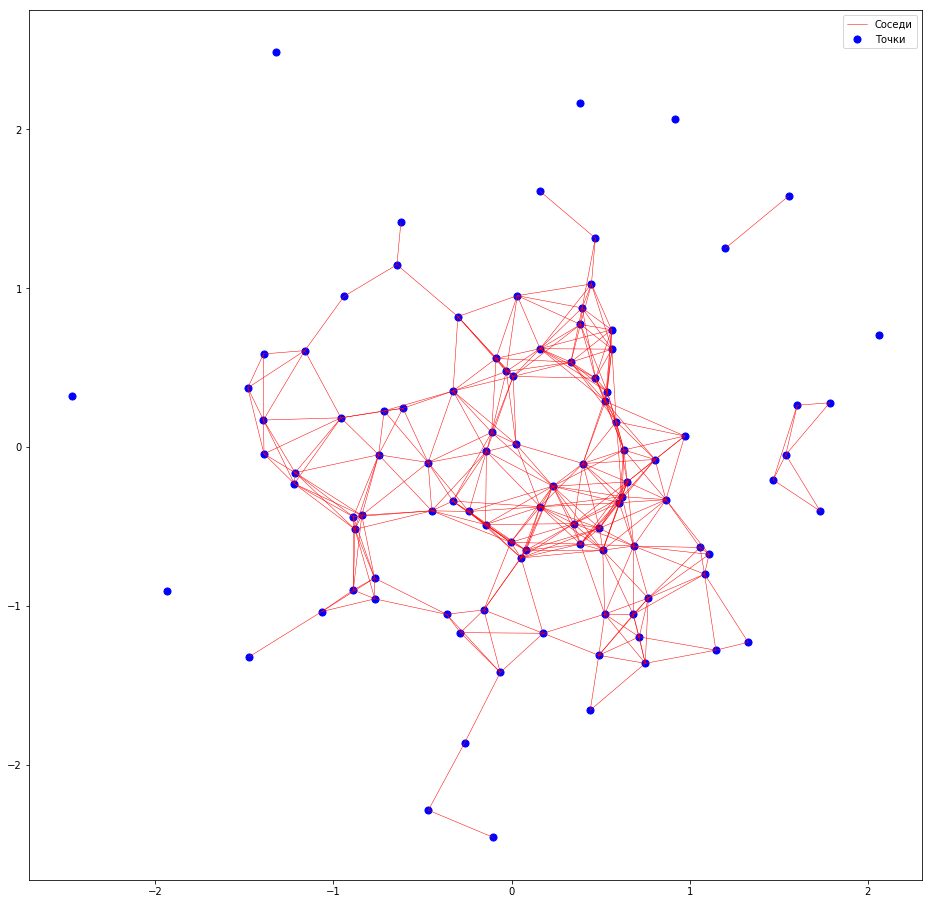

In [16]:
# np.random.seed(0)
n_points = 100
sigma = 1
distr = norm(0, sigma)
radius = 0.5
expected_neighbor_count = (1 - np.exp(- (radius / (2 * sigma)) ** 2)) * (n_points - 1)

points = distr.rvs((n_points, 2))

plt.figure(figsize=(16, 16))
for i, j in get_neigh_pairs(points, radius).T:
    x, y = points[[i, j]].T
    plt.plot(x, y, color="red", linewidth=0.5)
plt.plot([], [], color="red", linewidth=0.5, label="Соседи")
plt.scatter(points[:, 0], points[:, 1], color="blue", s=50, label="Точки")
plt.legend()
plt.show()

In [54]:
np.random.seed(0)
n_simulations = 1000
significance_level = 0.05
mistake_counts = {"quantile": 0, "norm": 0}
sampled_neigh_counts = []
for i in tqdm(range(n_simulations)):
    sample = distr.rvs((n_points, 2))
    neigh_pairs = get_neigh_pairs(sample, radius)
    neigh_count = 2 * neigh_pairs.shape[1] / n_points
    bootstrapped_neigh_counts = bootstrap_neigh_counts(n_points, neigh_pairs)

    intervals = calc_bootstrap_confidence_intervals(
        neigh_count, bootstrapped_neigh_counts,
        significance_level=significance_level
    )
    
    sampled_neigh_counts.append(neigh_count)
    for method, interval in intervals.items():
        if not is_in(expected_neighbor_count, interval):
            mistake_counts[method] += 1

sampled_neigh_counts = np.array(sampled_neigh_counts)

for method, method_mistake_count in mistake_counts.items():
    print("{:>10}: {}/{} mistakes, pvalue {:.5}".format(
        method, method_mistake_count, n_simulations,
        binom_test(method_mistake_count, n_simulations, p=significance_level)
    ))



  quantile: 48/1000 mistakes, pvalue 0.82783
      norm: 35/1000 mistakes, pvalue 0.02915


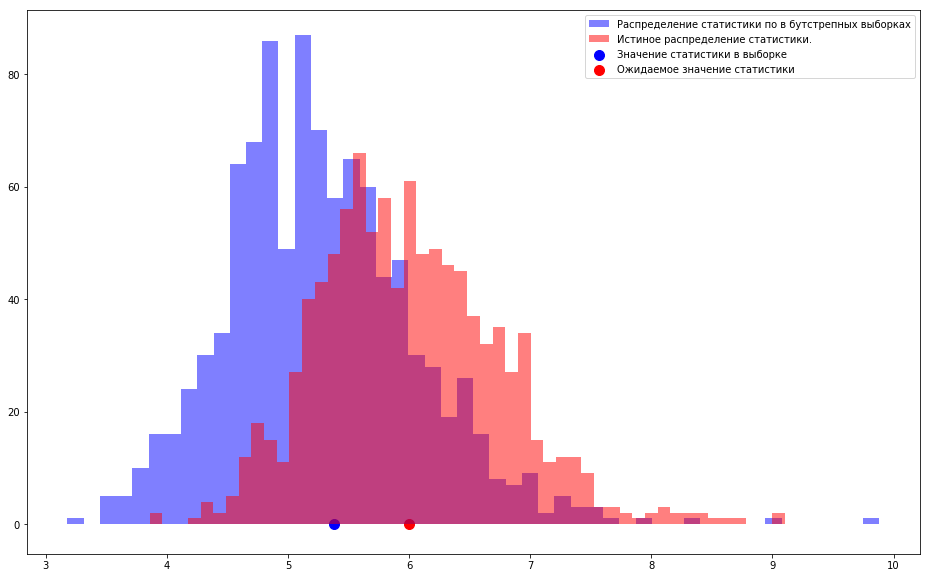

In [55]:
plt.figure(figsize=(16, 10))
plt.hist(bootstrepped_neigh_counts, bins=50, alpha=0.5, color="blue",
         label="Распределение статистики по в бутстрепных выборках")
plt.hist(sampled_neigh_counts, bins=50, alpha=0.5, color="red",
         label="Истиное распределение статистики.")
plt.scatter(neigh_count, 0, color="blue", label="Значение статистики в выборке", s=100)
plt.scatter(expected_neighbor_count, 0, color="red", label="Ожидаемое значение статистики", s=100)
plt.legend()
plt.show()

In [56]:
real_errs = sampled_neigh_counts - expected_neighbor_count
bootstrapped_errs = bootstrapped_neigh_counts - neigh_count
print(real_errs.mean(), bootstrapped_errs.mean())

0.004393218534105408 -0.10489999999999991
